# Overall description:

* *Visualization :* Observing dataset type,shape, data distribution type, correlation, GHI value over time.
* *Preprocessing :* I used stadanrdscaling for removing the mean and scaling the data to unit variance. i split the dataset manually for lstm_input. For other model, I used sklearn train_test_split.
* *Model training*: I trained three different NN model.SNN,FNN and LSTM. All hyperparameters were tuned by RANDPOMIZEDSEARCHCV. I haven't included that hyperparameter tunning part in this notebook. 
* *checking-error*: RMSE score
* *Ensembling :* Stacking_ensemble on pretrained model.
* *Weighted avg on prediction*: Gave weight to stacked_model,snn_model,lstm_model submission w.r.t to their accuracy on validation set.

* ***My personal insight on increasing accuracy:*** 
> I should have used a fixed validation set for checking unbiased validation error of those model and regularize stacked model based on that unbiased error, instead i trained 3 model on different notebook,based on different train_validation set.I load those pretrained model,in stacked model and got biased result.And when i find this mistake, the comp was nearly at end,had no time for fixing that.This mistake resulted slightly overfit on test set. Public score:112.67(3rd) ,private score: 113.65(4th)



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

In [2]:
#file="/content/gdrive/My Drive/Colab Notebooks/train.csv"
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [3]:
train.drop(["ID"], axis=1, inplace=True)


In [4]:
train.shape

(973439, 7)

# **Visualization**

In [5]:
train.describe()

,global_horizontal_irradiance,precipitation,atmospheric_pressure,relative_humidity,air_temperature,wind_direction,wind_speed
count,973439.000000,973439.000000,973439.000000,973439.000000,973439.000000,973439.000000,973439.000000
mean,191.172226,0.005469,1005.602558,87.557049,26.399821,184.860255,1.911692
std,282.451967,0.055166,5.393056,16.043781,4.758667,95.175636,1.216561
min,0.000000,0.000000,986.163000,19.935900,9.031670,0.001493,0.000000
25%,0.000000,0.000000,1001.310000,81.215200,24.137450,128.474500,1.039920
50%,4.626500,0.000000,1005.800000,94.236000,27.301300,172.408000,1.659100
75%,327.273500,0.000000,1010.020000,100.000000,29.317000,265.911000,2.538005
max,1486.420000,4.900000,1018.630000,100.000000,39.945800,360.000000,16.058250


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C505B69108>,
      dtype=object)

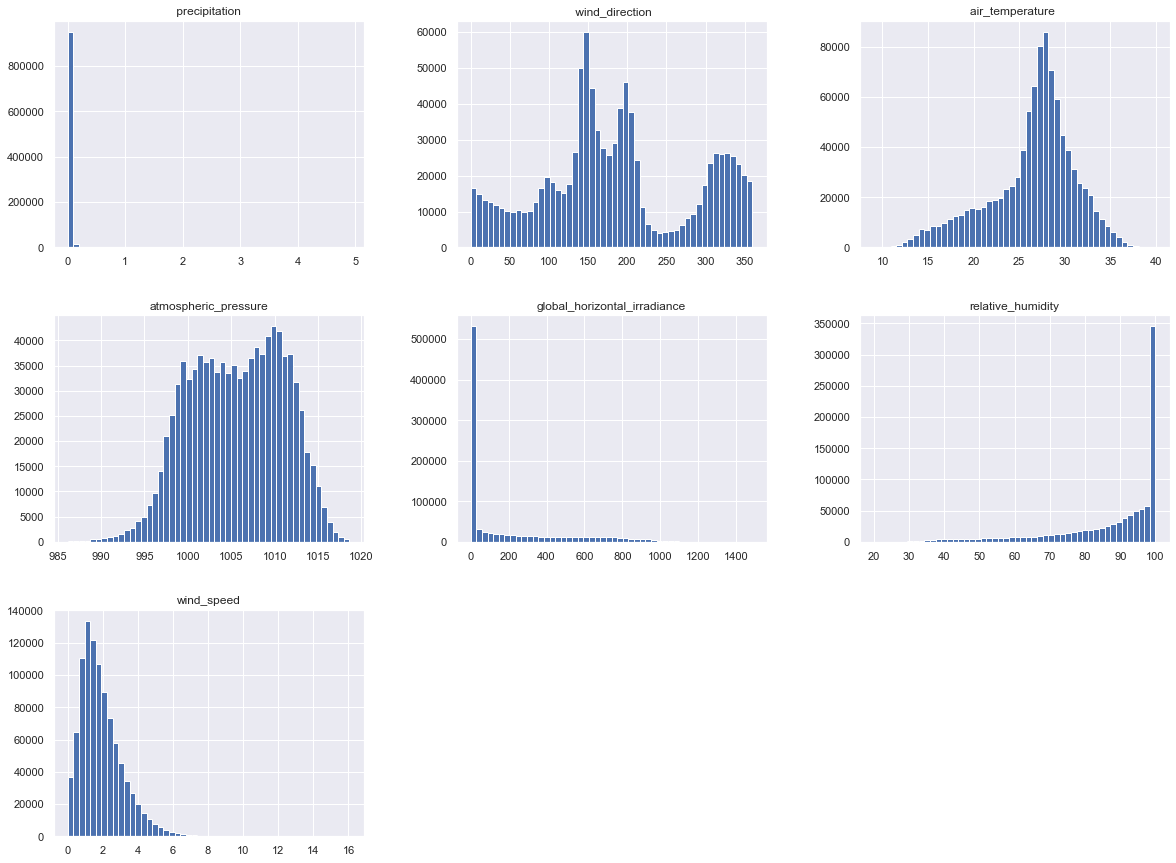

In [6]:
train.hist(bins=50,figsize=(20,15))

Normal distribution in air_temp,pressure.Poisson distribution in wind_speed. We will apply transformation to this later.

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973439 entries, 0 to 973438
Data columns (total 7 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   global_horizontal_irradiance  973439 non-null  float64
 1    precipitation                973439 non-null  float64
 2   atmospheric_pressure          973439 non-null  float64
 3   relative_humidity             973439 non-null  float64
 4   air_temperature               973439 non-null  float64
 5    wind_direction               973439 non-null  float64
 6   wind_speed                    973439 non-null  float64
dtypes: float64(7)
memory usage: 52.0 MB


No null value :) We hate null value >_<

(-10, 1602)

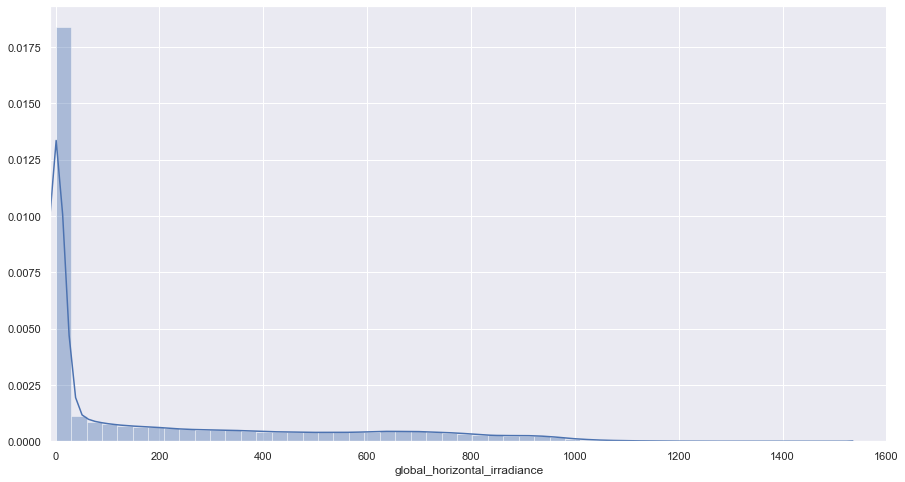

In [8]:
f, ax = plt.subplots(figsize=(15,8))
sns.distplot(train['global_horizontal_irradiance']) #for checking distribution of GHI
plt.xlim([-10,1602])

Most of the GHI value is distributed in zero.Lets see correlation between features for more insight.

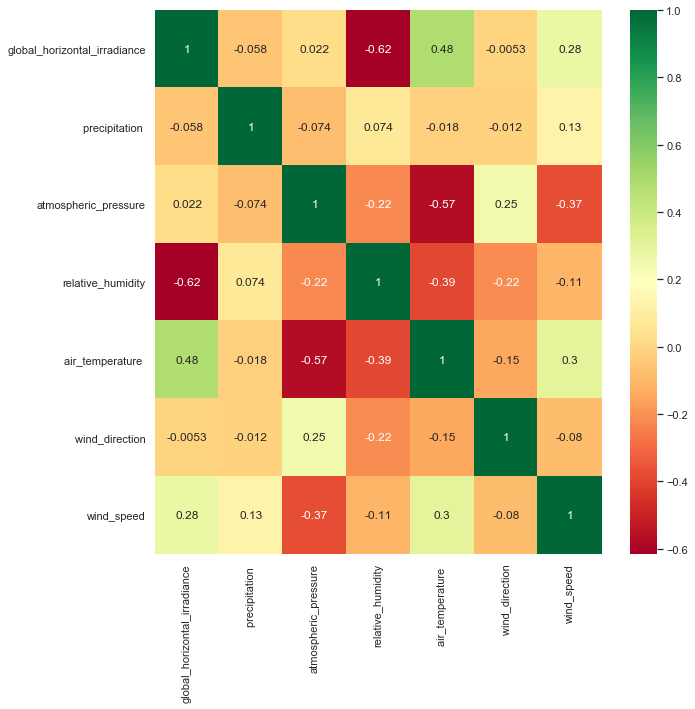

In [9]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(),annot=True,cmap='RdYlGn')

In [10]:
corr_matrix=train.corr()
print(corr_matrix['global_horizontal_irradiance'].sort_values(ascending=False))

global_horizontal_irradiance    1.000000
air_temperature                 0.483470
wind_speed                      0.279513
atmospheric_pressure            0.022162
 wind_direction                -0.005341
 precipitation                 -0.057924
relative_humidity              -0.615503
Name: global_horizontal_irradiance, dtype: float64


We can see ,wind_direction and precipitation is less correlated with GHI. But we cant drop those column bcz it has impact on solar prediction, And dropping columns hampers model accuracy also.

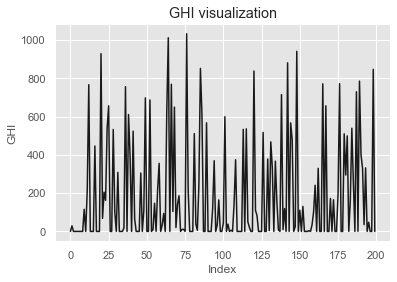

In [11]:
train_small=train[:200].copy()
plt.style.use('ggplot')
y=train_small['global_horizontal_irradiance']
x=range(200)

plt.plot(x,y,color='k')
plt.xlabel("Index")
plt.ylabel("GHI")
#Give graph a title
plt.title('GHI visualization')
plt.show()

This is a time series data, We can use RNN lstm on this data.

From above visualization and training on various model, I decided to train a 
1.SNN model(Selu+lecun_normal),as there is a great chance for exploding gradient
 2.A FNN model(He+he_normal and 
 3.LSTM model for time series.

**For LSTM, I didnt shuffle the dataset after preprocessing.

# Preprocessing & splitting the dataset

**I used 
1.log transformation
2.Square root transformation
3.Boxcox transformation
4.Standardscaling on train_data. Among them, i find standardscaling does better then all of them.

In [12]:
train_label=train["global_horizontal_irradiance"].copy()
train.drop(['global_horizontal_irradiance'], axis=1, inplace=True)
print(train.shape,train_label.shape)

(973439, 6) (973439,)


For lstm,(bcz we shouldnt feed shuffled data to lstm)

In [13]:
def processing(train_data):
    from sklearn.preprocessing import StandardScaler
    scaled_features = StandardScaler().fit_transform(train_data.values)
    scaled_data=pd.DataFrame(scaled_features,index=train_data.index,columns=train_data.columns)

    return scaled_data

X_train_lstm=processing(train)

In [14]:
data_len = len(X_train_lstm)
pct = 0.98 
train_len = int(pct*data_len)
train_data_lstm = X_train_lstm[:train_len]
train_label_lstm = train_label[:train_len].values

X_valid_lstm = X_train_lstm[train_len:]
y_valid_lstm = train_label[train_len:].values

train_data_lstm = train_data_lstm.values.reshape((train_data_lstm.shape[0],1,train_data_lstm.shape[1])) #for the lstm shape (None,time step,features)
X_valid_lstm = X_valid_lstm.values.reshape((X_valid_lstm.shape[0], 1, X_valid_lstm.shape[1]))
print(train_data_lstm.shape, train_label_lstm.shape, X_valid_lstm.shape,y_valid_lstm.shape) 

(953970, 1, 6) (953970,) (19469, 1, 6) (19469,)


For SNN and FNN

In [15]:
train_data=processing(train)

In [16]:
train_data, X_valid, train_label, y_valid = train_test_split(train_data, train_label, train_size=0.95,test_size = 0.05, random_state = 42)
print(train_data.shape,train_label.shape,X_valid.shape,y_valid.shape)

(924767, 6) (924767,) (48672, 6) (48672,)


# ***MODEL TRAINING***
***ALL HYPARPARAMETER WERE TUNED BY RANDOMIZEDSEARCHCV***

In [ ]:
from tensorflow import keras
import tensorflow as tf
from keras.layers import Dense
from keras.layers import AlphaDropout
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras import models
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Flatten

*SNN model
ACTIVATION="SELU",INIT="LECUN_NORMAL"*

In [ ]:
#reg = keras.regularizers.l1_l2(l1=0.01, l2=0.1) 
reg = keras.regularizers.l1_l2(l1=0.001, l2=0.01) 
dropout=0.2
snn_model = keras.models.Sequential([
        
        keras.layers.Input(shape=train_data.shape[1]),
        keras.layers.Dense(600, activation="selu",kernel_initializer="lecun_normal", kernel_regularizer=reg),
        #keras.layers.AlphaDropout(0.2),
    
        keras.layers.Dense(600, activation="selu",kernel_initializer="lecun_normal", kernel_regularizer=reg),
        #keras.layers.AlphaDropout(0.2),
    
        keras.layers.Dense(300, activation="selu",kernel_initializer="lecun_normal", kernel_regularizer=reg),
        #keras.layers.AlphaDropout(0.1),
     
        keras.layers.Dense(300, activation="selu",kernel_initializer="lecun_normal", kernel_regularizer=reg),
        #keras.layers.AlphaDropout(0.1),
    
        keras.layers.Dense(150, activation="selu",kernel_initializer="lecun_normal", kernel_regularizer=reg),
        #keras.layers.AlphaDropout(0.1),
        keras.layers.BatchNormalization(),
    
        keras.layers.Dense(150, activation="selu",kernel_initializer="lecun_normal", kernel_regularizer=reg),
        #keras.layers.AlphaDropout(0.05),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(150, activation="selu",kernel_initializer="lecun_normal", kernel_regularizer=reg),
        #keras.layers.AlphaDropout(0.05),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(100, activation="selu",kernel_initializer="lecun_normal", kernel_regularizer=reg),
        keras.layers.Dense(1)
])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
optimizer=keras.optimizers.Nadam(
    learning_rate=0.0009, beta_1=0.9, beta_2=0.999, epsilon=1e-07,decay=1e-09
)
model.compile(loss="mean_squared_error", optimizer=optimizer,metrics=['accuracy'])


*FNN MODEL
ACTIVATION="ELU",INIT="HE_NORMAL" WITH BATCHNORMALIZATION*

In [ ]:
reg = keras.regularizers.l1_l2(l1=0.001, l2=0.01) 
dropout=0.2
initializer = tf.keras.initializers.he_normal()
fnn_model = keras.models.Sequential([
        
        keras.layers.Input(shape=train_data.shape[1]),
        keras.layers.Dense(500, activation="elu",kernel_initializer=initializer, kernel_regularizer=reg),
        #keras.layers.AlphaDropout(dropout),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(500, activation="elu",kernel_initializer=initializer, kernel_regularizer=reg),
        #keras.layers.AlphaDropout(dropout),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(300, activation="elu",kernel_initializer=initializer, kernel_regularizer=reg),
        #keras.layers.AlphaDropout(0.1),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(300, activation="elu",kernel_initializer=initializer, kernel_regularizer=reg),
        #keras.layers.AlphaDropout(0.1),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(150, activation="elu",kernel_initializer=initializer, kernel_regularizer=reg),
        #keras.layers.AlphaDropout(0.1),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(150, activation="elu",kernel_initializer=initializer, kernel_regularizer=reg),
        #keras.layers.AlphaDropout(0.05),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(150, activation="elu",kernel_initializer=initializer, kernel_regularizer=reg),
        #keras.layers.AlphaDropout(0.05),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(100, activation="elu",kernel_initializer=initializer, kernel_regularizer=reg),
        keras.layers.Dense(1)
])
# def exponential_decay(lr0, s):
#     def exponential_decay_fn(epoch):
#         return lr0 * 0.1**(epoch / s)
#     return exponential_decay_fn
# exponential_decay_fn = exponential_decay(lr0=0.01, s=100)
#lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

optimizer=keras.optimizers.Nadam(
    learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-07,decay=1e-06
)
#lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
model.compile(loss="mean_squared_error", optimizer=optimizer,metrics=['accuracy'])

*LSTM Model

In [ ]:
reg = keras.regularizers.l1_l2(l1=0.0001, l2=0.01) 

lstm_model = keras.models.Sequential([
    keras.layers.Input(shape=(train_data_lstm.shape[1], train_data_lstm.shape[2])),
    keras.layers.LSTM(500,activation="selu",kernel_initializer="lecun_normal",return_sequences=True,kernel_regularizer=reg),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    
    keras.layers.LSTM(300,activation="selu",kernel_initializer="lecun_normal",return_sequences=True,kernel_regularizer=reg),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    
    keras.layers.LSTM(150,activation="selu",kernel_initializer="lecun_normal",return_sequences=True,kernel_regularizer=reg),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    
    keras.layers.LSTM(150,activation="selu",kernel_initializer="lecun_normal",return_sequences=True,kernel_regularizer=reg),
    keras.layers.BatchNormalization(),
    
    keras.layers.LSTM(100,activation="selu",kernel_initializer="lecun_normal",kernel_regularizer=reg),
    keras.layers.Dense(1)
])


optimizer=keras.optimizers.Nadam(
    learning_rate=0.0009, beta_1=0.9, beta_2=0.999, epsilon=1e-07,decay=1e-07)
model.compile(loss="mean_squared_error", optimizer=optimizer,metrics=['accuracy'])

In [ ]:
snn_model.summary()
fnn_model.summary()
lstm_model.summary()

***Model Training***

**SNN

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("snn_model_fromcallback_on_tuned_param.h5",
 save_best_only=True)
reduce_lr1 = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7,
                              patience=5, min_lr=0) #For stucked at plateu problem
reduce_lr2 = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0)

In [ ]:
history1 = snn_model.fit(train_data, train_label, epochs=130, batch_size=150, validation_data=(X_valid, y_valid), verbose=1) 
history2 = snn_model.fit(train_data, train_label, epochs=60, batch_size=512, validation_data=(X_valid, y_valid), verbose=1,callbacks=[checkpoint_cb,reduce_lr1]) 
history3 = snn_model.fit(train_data, train_label, epochs=40, batch_size=700, validation_data=(X_valid, y_valid), verbose=1,callbacks=[checkpoint_cb,reduce_lr2]) 

In [ ]:
pd.DataFrame(history1.history).plot(figsize=(8, 5)) #for checking learning_curve
plt.grid(True)
plt.gca() 
plt.show()

**FNN

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("fnn_he_model_fromcallback_on_tuned_param.h5",
 save_best_only=True)
reduce_lr1 = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7,
                              patience=5, min_lr=0)
reduce_lr2 = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=3, min_lr=0)

In [ ]:
history1 = fnn_model.fit(train_data, train_label, epochs=130, batch_size=256, validation_data=(X_valid, y_valid), verbose=1) 
history2 = fnn_model.fit(train_data, train_label, epochs=60, batch_size=512, validation_data=(X_valid, y_valid), verbose=1,callbacks=[checkpoint_cb,reduce_lr1]) 
history3 = fnn_model.fit(train_data, train_label, epochs=40, batch_size=1024, validation_data=(X_valid, y_valid), verbose=1,callbacks=[checkpoint_cb,reduce_lr2])

Lets check the learning_curve

In [ ]:
pd.DataFrame(history1.history).plot(figsize=(8, 5)) #for checking learning_curve
plt.grid(True)
plt.gca() 
plt.show()

**LSTM

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("lstm_model_fromcallback_on_tuned_param.h5",
 save_best_only=True)
reduce_lr1 = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7,
                              patience=5, min_lr=0)
reduce_lr2 = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=4, min_lr=0)
reduce_lr2 = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=3, min_lr=0)

In [ ]:
history1 = lstm_model.fit(train_data_lstm, train_label_lstm, epochs=130, batch_size=256, validation_data=(X_valid_lstm, y_valid-lstm), verbose=1,callbacks=[reduce_lr1]) 
history2 = lstm_model.fit(train_data_lstm, train_label_lstm, epochs=60, batch_size=512, validation_data=(X_valid_lstm, y_valid-lstm), verbose=1,callbacks=[checkpoint_cb,reduce_lr1]) 
history3 = lstm_model.fit(train_data_lstm, train_label_lstm, epochs=40, batch_size=1024, validation_data=(X_valid_lstm, y_valid-lstm), verbose=1,callbacks=[checkpoint_cb,reduce_lr2])

***RMSE checking on validation set

In [ ]:
from sklearn.metrics import mean_squared_error

pred_snn = snn_model.predict(X_valid)
basic_mse=mean_squared_error(y_valid,pred_snn)
basic_mse_snn=np.sqrt(basic_mse)
print(basic_mse_snn) #117.67

Train error : 104.21, validation error: 117.67

In [ ]:
pred_fnn = fnn_model.predict(X_valid)
basic_mse_fnn=np.sqrt(mean_squared_error(y_valid,pred_fnn))
print(basic_mse_fnn) #120.19

Train error : 107.88, validation error: 120.19

In [ ]:
pred_lstm = lstm_model.predict(X_valid_lstm)
basic_mse_lstm=np.sqrt(mean_squared_error(y_valid_lstm,pred_lstm))
print(basic_mse_lstm) #119.01

Train error : 105.36, validation error: 119.01

# ENSEMBLING MODEL

In [ ]:
all_models=list()

model=keras.models.load_model("snn_model_fromcallback_on_tuned_param.h5")
all_models.append(model)
model=keras.models.load_model("lstm_model_fromcallback_on_tuned_param.h5")
all_models.append(model)
model=keras.models.load_model("fnn_he_model_fromcallback_on_tuned_param.h5")
all_models.append(model)


In [ ]:
def stacked_dataset(members, inputX):
    
    stackX=None
    yhat=members[0].predict(inputX, verbose=0)
    stackX=yhat

    input_X_lstm=inputX.values.reshape((inputX.shape[0], 1, inputX.shape[1]))
    yhat=members[1].predict(input_X_lstm, verbose=0)
    stackX = np.concatenate((stackX,yhat),axis=1)

    yhat=members[2].predict(inputX, verbose=0)
    stackX = np.concatenate((stackX,yhat),axis=1)

    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]))
    return stackX    

In [ ]:
def create_model(stackedX):
    
    
    reg = keras.regularizers.l1_l2(l1=0.001, l2=0.01) 
    dropout=0.2
    #initializer = tf.keras.initializers.he_normal()
    model = keras.models.Sequential([
                  
      keras.layers.Input(shape=(stackedX.shape[1], stackedX.shape[2])),
      keras.layers.LSTM(500,activation="selu",kernel_initializer="lecun_normal",return_sequences=True,kernel_regularizer=reg),
      keras.layers.Dropout(0.2),
      keras.layers.BatchNormalization(),
    
      keras.layers.LSTM(300,activation="selu",kernel_initializer="lecun_normal",return_sequences=True,kernel_regularizer=reg),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.1),
    
      keras.layers.LSTM(150,activation="selu",kernel_initializer="lecun_normal",return_sequences=True,kernel_regularizer=reg),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.1),
    
      keras.layers.LSTM(150,activation="selu",kernel_initializer="lecun_normal",return_sequences=True,kernel_regularizer=reg),
      keras.layers.BatchNormalization(),
    
      keras.layers.LSTM(100,activation="selu",kernel_initializer="lecun_normal",kernel_regularizer=reg),
      keras.layers.Dense(1)

             ])
 
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
    optimizer=keras.optimizers.Nadam(
        learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-07,decay=1e-06
    )
    model.compile(loss="mean_squared_error", optimizer=optimizer,metrics=['accuracy'])
    return model

In [ ]:
def dividing_stacked(stackedX,inputy):
    data_len = len(inputy)
    pct = 0.90 # change it to 0.8~0.9
    test_len = int(pct*data_len)
    X_train = stackedX[:test_len,:]
    y_train = inputy[:test_len]

    X_valid = stackedX[test_len:,:]
    y_valid = inputy[test_len:]

    X_train=X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_valid =X_valid .reshape((X_valid .shape[0], 1, X_valid .shape[1]))

    print(stackedX.shape,inputy.shape,X_train.shape,y_train.shape,X_valid.shape,y_valid.shape)
    return X_train,y_train,X_valid,y_valid

In [ ]:
def processing_stack(train_data):
    
    scaled_features = StandardScaler().fit_transform(train_data)
    return scaled_features


In [ ]:
def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    
    stackedX = processing_stack(stackedX)
    #make a slice for validation info
    stackedX,inputy,stackedX_slice,inputy_slice = dividing_stacked(stackedX,inputy)
 
    nn_model = create_model(stackedX)

    history1=nn_model.fit(stackedX, inputy, epochs=130, validation_data=(stackedX_slice, inputy_slice),batch_size=256,verbose=1,callbacks=[reduce_lr1])
    history2=nn_model.fit(stackedX, inputy, epochs=50, validation_data=(stackedX_slice, inputy_slice),batch_size=512,verbose=1,callbacks=[checkpoint_cb,reduce_lr2])
    history3=nn_model.fit(stackedX, inputy, epochs=40, validation_data=(stackedX_slice, inputy_slice),batch_size=800,verbose=1,callbacks=[checkpoint_cb,reduce_lr3])
    
    return nn_model,history1

In [ ]:
def stacked_prediction(members, model, inputX):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    #processing
    stackedX = processing_stack(stackedX)
    # make a prediction
    yhat = model.predict(stackedX)
    return yhat

In [ ]:
model,history = fit_stacked_model(all_models, train_data, train_label)
# evaluate model on test set
yhat = stacked_prediction(all_models, model, X_valid)

In [ ]:
stacked_mse=mean_squared_error(y_valid,yhat)  # mse on validation set
stacked_mse=np.sqrt(stacked_mse)
print(stacked_mse)  #115.42

Validation error : 115.42

# TEST set prediction

We will take the outpput from three model. The stacked model, SNN model and LSTM model, And apply weighted avg on them.

***WEIGHTED AVERAGE On 3 PREDICTION***
**from previous:
*    stacked model rmse on validation set: 115.42
*    lstm model rmse on validation set: 119.01
*    snn model rmse on validation set: 117.67


In [ ]:
test=pd.read_csv("test.csv")
test_ID = test['ID'].values.reshape(len(test))
test.drop(['ID'], axis=1, inplace=True)

In [ ]:
X_test=processing(test)
print(X_test.columns,X_test.shape)

In [ ]:
X_test_lstm = X_test.values.reshape((X_test.shape[0],1,X_test.shape[1])) # preparing for lstm

In [ ]:
test_pred_stacked = stacked_prediction(all_models, model, X_test) #prediction of stacked model (validation set rmse:)

test_pred_lstm = lstm_model.predict(X_test_lstm) #prediction of previously trained lstm

test_pred_snn = snn_model.predict(X_test) #prediction of previously trained snn

In [ ]:
coefs = [0.60, 0.25, 0.15]

test_pred = test_pred_stacked * coefs[0] + test_pred_lstm * coefs[1] + test_pred_snn * coefs[2]


In [ ]:
preds = [0 if p<0 else p for p in test_pred]

In [ ]:
zippedList =  list(zip(test_ID, preds))
submission = pd.DataFrame(zippedList, columns = ['ID','global_horizontal_irradiance'])
submission=submission.explode('global_horizontal_irradiance')
submission.to_csv('submission_level5', index=False)  #PUBLIC leaderboard score: 112.67